In [397]:
# Import torch
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from helper_functions import *
# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

In [398]:
# Setup device agnostic code
# device = "cuda" if torch.cuda.is_available() else "cpu"
device="cpu"
device

'cpu'

# Get data


In [399]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


See what we're working with first

In [400]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [401]:
import random
import torchvision.transforms as transforms
from PIL import Image
# Visualize image
def visualize_processing(image_path, process_method=None, device='cpu'):
    img = Image.open(image_path).convert('RGB')
    print(f"original size: {img.size}")
    
    transform = transforms.Compose([
        transforms.Resize((64, 64)),  
        transforms.ToTensor(),        
    ])
    
    img_tensor = transform(img).unsqueeze(0).to(device)  # Shape: [1, 3, 64, 64]

    fig = plt.figure(figsize=(9, 9))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title("Original Image")
    ax1.imshow(img_tensor.squeeze().permute(1, 2, 0).cpu())  # [H, W, C]
    ax1.axis('off')
    if process_method is not None:
        processed = process_method(img_tensor)

        ax2 = fig.add_subplot(1, 2, 2)
        ax2.set_title("Processed Output (Channel 0)")
        processed_img = processed[0, 0, :, :].detach().cpu() 
        print(f"augement size: {processed.shape}")
        ax2.imshow(processed_img, cmap='gray')
        ax2.axis('off')
    
    plt.show()

original size: steak
original size: (512, 384)


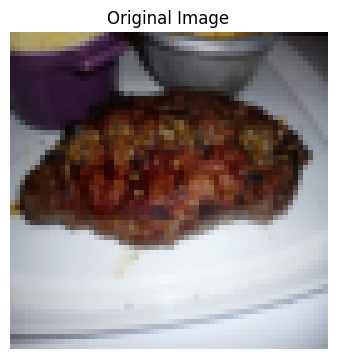

In [402]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
print(f"original size: {image_class}")
visualize_processing(random_image_path)

B..but I want to load my data to pytorch!
Calm down, before loading, we need a couple of things
1. Turn to tensors
2. Turn into Dataset and Dataloader(each differs, either torchaudio, torchvision, or torchrec)

original size: (512, 384)
augement size: torch.Size([1, 3, 64, 64])


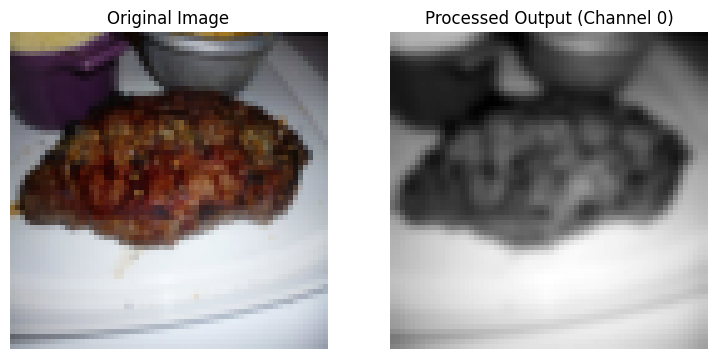

original size: (512, 384)
augement size: torch.Size([1, 3, 64, 64])


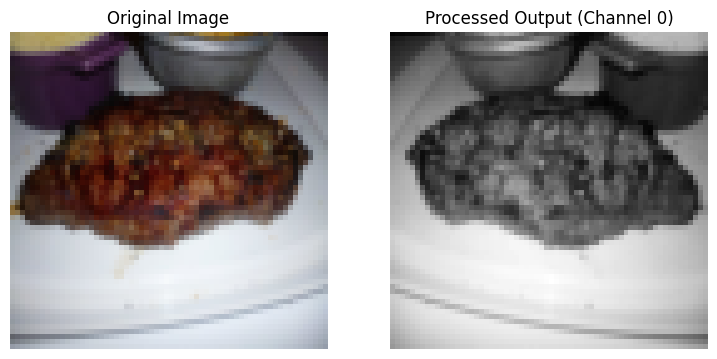

In [403]:
# Using torchvision transform, we resize and randomly flip it horizontal, then transform to tensor
def transform_img_once(img):
    data_transform = transforms.Compose([
        transforms.Resize(size=(64, 64)),
        transforms.GaussianBlur(5),
        transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
        # transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
    ])
    return data_transform(img).to(device)  
visualize_processing(random_image_path, transform_img_once)

# but to be fair, there are other methods, such as shearin, erasing, rotating
# this is the core of augmentation,the process of altering data so that you have a diverse training set
# lets see one exaple of the other types
#  trivialaugment: you have a set of transforms and you pick some to transform the image

def transform_img_trivial(img):
    data_transform = transforms.Compose([
        transforms.Resize(size=(64, 64)),
        transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense 
        transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
        # transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
    ])
    return data_transform(img).to(device) 
visualize_processing(random_image_path, transform_img_trivial)

In [404]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [405]:
# Okay, now we can load our datasets

train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
# we assign transforms and transform, while label transformation(target trabsform) is none
train_data = torchvision.datasets.ImageFolder(root=train_dir, transform=train_transforms,target_transform=None)
test_data = torchvision.datasets.ImageFolder(root=test_dir, transform=test_transforms,target_transform=None)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


We can also create a custom dataset to replicate ImageFolder
Here are the steps:
1. Subclass torch.utils.Dataset
2. Intialize subclass wuth targ_dir
3. Create attributes for paths, transform, classes, class_to_idx
4. Create a funtion to load and return images
5. ovrwrite \_\_len\_\_ to return the number of dataset samples
5. ovrwrite \_\_getitem\_\_ to return single sample of the dataset

In [406]:

import pathlib
from typing import Dict, Tuple
from torch.utils.data import Dataset


# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [407]:

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
    # 3. Create class attributes
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        # path should be data_folder/class_name/image.jpeg
        class_name  = self.paths[index].parent.name 
        class_idx = self.class_to_idx[class_name]

        # Transform if you want necessary
        if self.transform:
            # return data, label (X, y)
            return self.transform(img), class_idx 
        else:
            # return data, label (X, y)
            return img, class_idx 

In [408]:

train_data_custom = ImageFolderCustom(targ_dir=train_dir, 
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, 
                                     transform=test_transforms)

print(f"Train data:\n{train_data_custom}\nTest data:\n{test_data_custom}")

Train data:
Test data:


In [409]:
len(train_data_custom), len(test_data_custom)

(225, 75)

The custom works as expected, now towards taking them in to display


In [410]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

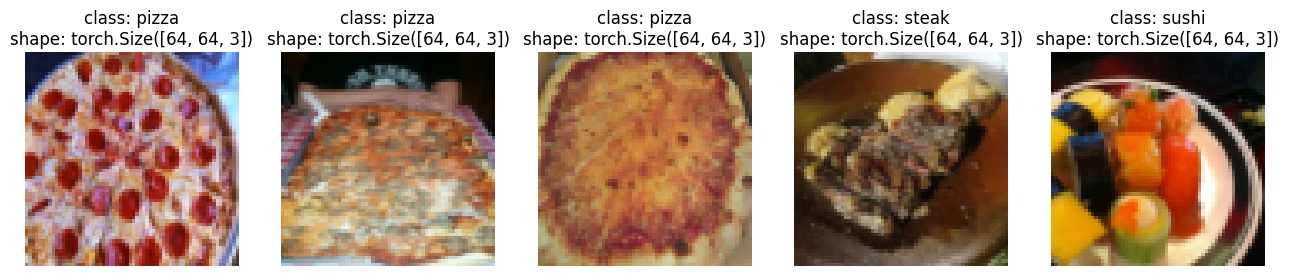

In [411]:
display_random_images(train_data, 
                      n=5, 
                      classes=train_data.classes,
                      seed=None)

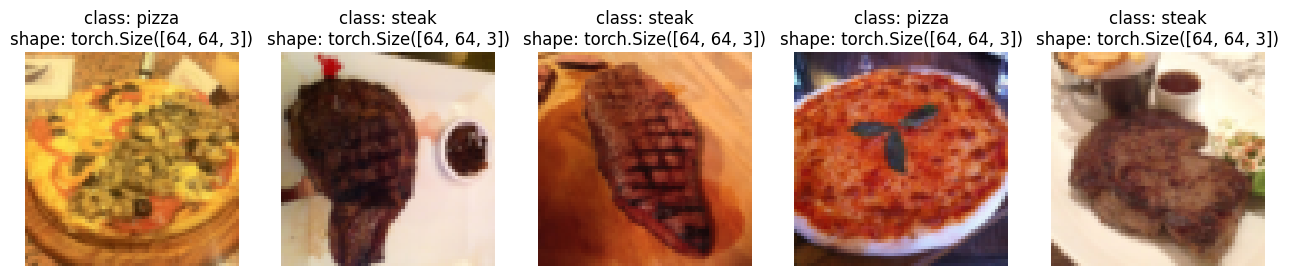

In [412]:
display_random_images(train_data_custom, 
                      n=5, 
                      classes=train_data_custom.classes,
                      seed=None)

Great, now we can also chedk the labels

In [413]:
#  we can see the classes here
train_data.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [414]:
# we can also print the image to check datatypes
img, label = train_data[0][0], train_data[0][1]
# print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image shape: torch.Size([3, 64, 64])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


then we can go make them into DataLoader

Turning our Dataset's into DataLoader's makes them iterable so 
a model can go through and learn the relationships between samples and targets (features and labels

num workers define how many subprocess will be created to load

In [415]:
os.cpu_count()

128

In [416]:
# train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

# img, label = next(iter(train_dataloader))

# # Batch size will now be 1, try changing the batch_size parameter above and see what happens
# print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
# print(f"Label shape: {label.shape}")

train_dataloader_custom = torch.utils.data.DataLoader(train_data_custom, batch_size=1, shuffle=True)
test_dataloader_custom = torch.utils.data.DataLoader(test_data_custom, batch_size=1, shuffle=False)

img, label = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


# with everything done, lets talk about overfitting and underfitting
1. Overfitting
   a model that performs better on the training set rather than the validation/test set
2. underfitting
   a model that does not perform well on training and validation/test set

   ![Over and under](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-loss-curves-overfitting-underfitting-ideal.jpg)

B..but how do we prevent overfitting? qwq

Here's how:
1. Get more data
2. Reduce complexity of the model that is learning the data patterns too well
3. Augment data
4. Use transfer learning(uses someone else's model as a base)
5. Use dropout layers(randomly remove nn connections)
6. Use learning rate decay(slowly decrease learning rate)
7. Early stopping(stop learning before it overfits)

What about the other one? underfitting
1. Add more layers so it learns the pattern  of the data
2. Tweak learning rate, maybe your model is trying to update too much
3. Train longer so it converges
4. Use less regularization, maybe your attempts on preventing overfitting is holding back

Transfer learning is perhaps one of the most powerful techniques when it comes to dealing with both overfitting and underfitting on your own problems - This machine learning article I'm following

# Time To Train!!


In [417]:
# Create training transform with TrivialAugment
import os

train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() 
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

# Turn Datasets into DataLoader's

BATCH_SIZE = 32
NUM_WORKERS = 10

torch.manual_seed(42)
train_dataloader_augmented = torch.utils.data.DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = torch.utils.data.DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)


class TinyVGG(nn.Module):
    def __init__(self, input_shape, output_shape):
        super().__init__()
        self.block=torch.nn.Sequential(
            torch.nn.Conv2d(input_shape,10,3,1,1),
            torch.nn.Conv2d(10,10,3,1,1),
            torch.nn.ReLU(),
            # 
            torch.nn.Conv2d(10,10,3,1,1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            # 
            torch.nn.Conv2d(10,10,3,1,1),
            torch.nn.ReLU(),
            # 
            torch.nn.Conv2d(10,10,3,1,1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            # 
            torch.nn.Flatten(),
            torch.nn.Linear(32*80,out_features=output_shape)
            )

    def forward(self, x):
        return self.block(x)

tinyvgg = TinyVGG(3,
    output_shape=len(train_data_augmented.classes)).to(device)


In [418]:
tinyvgg

TinyVGG(
  (block): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [419]:
from tqdm.auto import tqdm


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=tinyvgg.parameters(), 
                            lr=0.1)
epochs=15
train_loss_values=[]
test_loss_values=[]
train_acc_values=[]
test_acc_values=[]
epoch_count =[]
for epoch in tqdm(range(epochs)):
    print(f"epoch: {epoch}")
    tinyvgg.to(device)
    tinyvgg.train()
    train_loss, train_acc = 0, 0
    test_loss, test_acc = 0, 0
    for batch, (X,y) in enumerate(train_dataloader_augmented):
        X,y=X.to(device),y.to(device)
        # forward pass
        # 32 batch, 1 channel, 32x32 size
        # print(X.shape)
        logits=tinyvgg(X)
        # error
        # print(f"{logits.shape} : {y.shape}")
        loss=loss_fn(logits,y)
        train_loss+=loss
        # gets the highest from the logits
        
        train_acc+=accuracy_fn(y, logits.argmax(dim=1))
        # zero grad
        optimizer.zero_grad()
        # loss backward
        loss.backward()
        # backprop
        optimizer.step()
    train_loss /= len(train_dataloader_augmented)
    train_acc /= len(train_dataloader_augmented)
    tinyvgg.to(device)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    tinyvgg.eval()
    with torch.inference_mode():
        for X,y in test_dataloader_simple:
            X, y = X.to(device), y.to(device)
            test_logits=tinyvgg(X)
            test_loss+=loss_fn(test_logits,y)
            test_acc+=accuracy_fn(y, test_logits.argmax(dim=1))
        test_loss /= len(test_dataloader_simple)
        test_acc /= len(test_dataloader_simple)
    train_loss_values.append(train_loss.detach().numpy())
    train_acc_values.append(train_acc)
    test_loss_values.append(test_loss.detach().numpy())
    test_acc_values.append(test_acc)
    epoch_count.append(epoch)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")

  0%|          | 0/15 [00:00<?, ?it/s]

epoch: 0
Train loss: 1.10380 | Train accuracy: 28.12%


  7%|▋         | 1/15 [00:01<00:25,  1.81s/it]

Test loss: 1.02740 | Test accuracy: 54.17%
epoch: 1
Train loss: 1.10675 | Train accuracy: 28.12%


 13%|█▎        | 2/15 [00:03<00:22,  1.72s/it]

Test loss: 1.09770 | Test accuracy: 26.04%
epoch: 2
Train loss: 1.10097 | Train accuracy: 30.47%


 20%|██        | 3/15 [00:05<00:20,  1.74s/it]

Test loss: 1.07724 | Test accuracy: 54.17%
epoch: 3
Train loss: 1.10750 | Train accuracy: 28.12%


 27%|██▋       | 4/15 [00:06<00:18,  1.71s/it]

Test loss: 1.10075 | Test accuracy: 19.79%
epoch: 4
Train loss: 1.09938 | Train accuracy: 29.30%


 33%|███▎      | 5/15 [00:08<00:17,  1.77s/it]

Test loss: 1.11039 | Test accuracy: 26.04%
epoch: 5
Train loss: 1.10192 | Train accuracy: 30.47%


 40%|████      | 6/15 [00:10<00:16,  1.81s/it]

Test loss: 1.12308 | Test accuracy: 19.79%
epoch: 6
Train loss: 1.09635 | Train accuracy: 27.73%


 47%|████▋     | 7/15 [00:12<00:14,  1.76s/it]

Test loss: 1.12899 | Test accuracy: 26.04%
epoch: 7
Train loss: 1.11077 | Train accuracy: 30.47%


 53%|█████▎    | 8/15 [00:13<00:12,  1.73s/it]

Test loss: 1.10086 | Test accuracy: 26.04%
epoch: 8
Train loss: 1.10214 | Train accuracy: 30.47%


 60%|██████    | 9/15 [00:15<00:10,  1.75s/it]

Test loss: 1.11747 | Test accuracy: 19.79%
epoch: 9
Train loss: 1.09533 | Train accuracy: 41.41%


 67%|██████▋   | 10/15 [00:17<00:08,  1.72s/it]

Test loss: 1.13063 | Test accuracy: 19.79%
epoch: 10
Train loss: 1.09215 | Train accuracy: 41.41%


 73%|███████▎  | 11/15 [00:19<00:06,  1.70s/it]

Test loss: 1.14080 | Test accuracy: 19.79%
epoch: 11
Train loss: 1.11406 | Train accuracy: 29.30%


 80%|████████  | 12/15 [00:20<00:05,  1.71s/it]

Test loss: 1.11019 | Test accuracy: 19.79%
epoch: 12
Train loss: 1.10434 | Train accuracy: 29.30%


 87%|████████▋ | 13/15 [00:22<00:03,  1.73s/it]

Test loss: 1.08998 | Test accuracy: 54.17%
epoch: 13
Train loss: 1.10591 | Train accuracy: 28.12%


 93%|█████████▎| 14/15 [00:24<00:01,  1.76s/it]

Test loss: 1.10144 | Test accuracy: 26.04%
epoch: 14
Train loss: 1.09577 | Train accuracy: 42.58%


100%|██████████| 15/15 [00:26<00:00,  1.75s/it]

Test loss: 1.11232 | Test accuracy: 26.04%


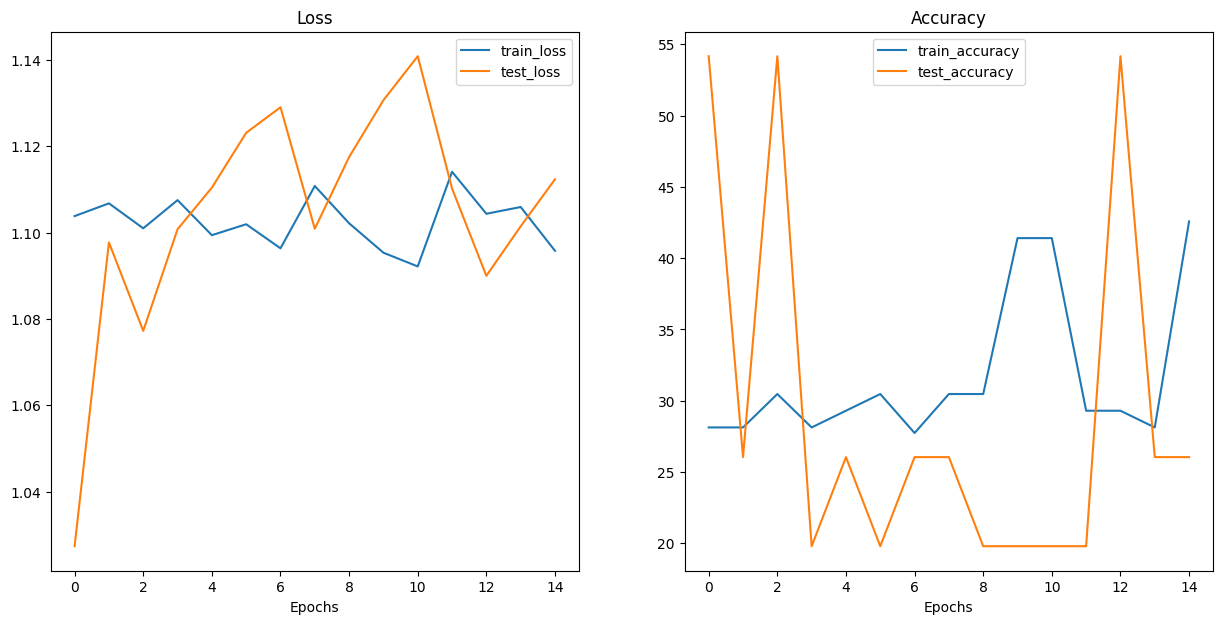

In [420]:
history = {
    "train_loss": train_loss_values,
    "train_acc": train_acc_values,
    "test_loss": test_loss_values,
    "test_acc": test_acc_values
}
plot_loss_curves(history)

# OHMYGODITSHORRIBLERINSEITWITHFIRE
I think it's sporadic, maybe overfitting?
alright, whatever that, lets just make predictions!

In [ ]:


import torchvision
custom_image_path = data_path / "arupizza.png"
custom_image_path = data_path / "arupizza.png"
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

custom_image = custom_image_uint8 / 255.
custom_image = custom_image[:3, :, :]  # Shape now [3, H, W]
# Resize to 64x64
transform = transforms.Compose([
    transforms.Resize((64, 64))
])

custom_image_resized = transform(custom_image)
custom_image_batch = custom_image_resized.unsqueeze(0)  # Shape [1, 3, 64, 64]

custom_image_batch = custom_image_batch.to(device)

tinyvgg.eval()
with torch.inference_mode():
    output = tinyvgg(custom_image_batch)
custom_image_pred_probs = torch.softmax(output, dim=1)
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_class = train_data_augmented.classes[custom_image_pred_label.cpu()]



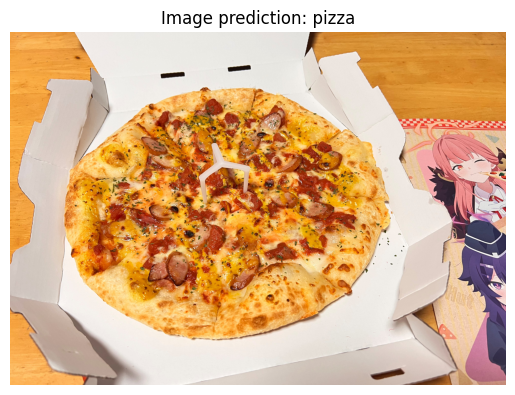

In [442]:
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.title(f"Image prediction: {custom_image_pred_class}")
plt.axis(False);